Installation und Import der nötigen Bibliotheken

In [1]:
%pip install pandas
%pip install matplotlib
%pip install pillow
%pip install numpy
%pip install openpyxl

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from PIL import Image
import numpy as np
from openpyxl import load_workbook
import os

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Einlesen der CSVs

In [2]:
cmf_path = '../input files/cmf.csv'
spectrum_path = '../input files/CIE_std_illum_D65.csv'

columns_cmf = ["Wavelength", "x", "y", "z", "Column1", "Column2", "Column3", "Column4"]
columns_spectrum = ["Wellenlänge", "Intensität"]

cmf = pd.read_csv(cmf_path, header=None, names=columns_cmf)
cmf = cmf.drop(columns=["Column1", "Column2", "Column3", "Column4"])
spectrum = pd.read_csv(spectrum_path, header=None, names=columns_spectrum)
spectrum = spectrum[(spectrum['Wellenlänge'] >= 380) & (spectrum['Wellenlänge'] <= 780)]
spectrum = spectrum[spectrum['Wellenlänge'] % 5 == 0]

print("CMF DataFrame 1:")
print(cmf.head())

print("\nSpectrum DataFrame 2:")
print(spectrum.head())

CMF DataFrame 1:
   Wavelength       x       y       z
0         380  0.0014  0.0000  0.0065
1         385  0.0022  0.0001  0.0105
2         390  0.0042  0.0001  0.0201
3         395  0.0076  0.0002  0.0362
4         400  0.0143  0.0004  0.0679

Spectrum DataFrame 2:
     Wellenlänge  Intensität
80           380     49.9755
85           385     52.3118
90           390     54.6482
95           395     68.7015
100          400     82.7549


Anwendung der CMF

In [3]:
merged_df = pd.merge(spectrum, cmf, left_on='Wellenlänge', right_on='Wavelength')
merged_df = merged_df.drop(columns=['Wavelength'])

merged_df['X'] = merged_df['Intensität'] * merged_df['x']
merged_df['Y'] = merged_df['Intensität'] * merged_df['y']
merged_df['Z'] = merged_df['Intensität'] * merged_df['z']

print("Merged Spectrum DataFrame:")
print(merged_df)

Merged Spectrum DataFrame:
    Wellenlänge  Intensität       x       y       z         X         Y  \
0           380     49.9755  0.0014  0.0000  0.0065  0.069966  0.000000   
1           385     52.3118  0.0022  0.0001  0.0105  0.115086  0.005231   
2           390     54.6482  0.0042  0.0001  0.0201  0.229522  0.005465   
3           395     68.7015  0.0076  0.0002  0.0362  0.522131  0.013740   
4           400     82.7549  0.0143  0.0004  0.0679  1.183395  0.033102   
..          ...         ...     ...     ...     ...       ...       ...   
76          760     46.4182  0.0002  0.0001  0.0000  0.009284  0.004642   
77          765     56.6118  0.0002  0.0001  0.0000  0.011322  0.005661   
78          770     66.8054  0.0001  0.0000  0.0000  0.006681  0.000000   
79          775     65.0941  0.0001  0.0000  0.0000  0.006509  0.000000   
80          780     63.3828  0.0000  0.0000  0.0000  0.000000  0.000000   

           Z  
0   0.324841  
1   0.549274  
2   1.098429  
3   2.486994

Aufsummierung & Normalisierung

In [4]:
sum_X = merged_df['X'].sum()
sum_Y = merged_df['Y'].sum()
sum_Z = merged_df['Z'].sum()

norm_sum_X = ((sum_X * 683) / sum_Y)
norm_sum_Y = ((sum_Y * 683) / sum_Y)
norm_sum_Z = ((sum_Z * 683) / sum_Y)
 
print(f"Summe X: {norm_sum_X}")
print(f"Summe Y: {norm_sum_Y}")
print(f"Summe Z: {norm_sum_Z}")

output_path = '../output files/spectrum_output.csv'
merged_df.to_csv(output_path, index=False)

Summe X: 647.8252184114104
Summe Y: 683.0
Summe Z: 742.1387009854793


x/y-Koordinaten

In [5]:
norm_total_sum_XYZ = norm_sum_X + norm_sum_Y + norm_sum_Z
x = (norm_sum_X / norm_total_sum_XYZ)
y = (norm_sum_Y / norm_total_sum_XYZ)

print(f"x: {x}")
print(f"y: {y}")

x: 0.3125115745381084
y: 0.32947992659646136


Fehlerinjektion in CMF

In [6]:
wavelength_shift_steps = 2 # Tests mit Verschiebung in positiv und negativ: 2(10nm), 5(25nm) und 10(50nm)
x_shift_steps = 0 # Tests mit Verschiebung in positiv und negativ: 2(10nm), 5(25nm) und 10(50nm), sowie in Kombination mit y und z
y_shift_steps = 0 # Tests mit Verschiebung in positiv und negativ: 2(10nm), 5(25nm) und 10(50nm), sowie in Kombination mit x und z
z_shift_steps = 0 # Tests mit Verschiebung in positiv und negativ: 2(10nm), 5(25nm) und 10(50nm), sowie in Kombination mit x und y

cmf_fault = cmf.copy()

cmf_fault['Wavelength'] = cmf_fault['Wavelength'].shift(wavelength_shift_steps)
cmf_fault['x'] = cmf_fault['x'].shift(x_shift_steps)
cmf_fault['y'] = cmf_fault['y'].shift(y_shift_steps)
cmf_fault['z'] = cmf_fault['z'].shift(z_shift_steps)

merged_fault_df = pd.merge(spectrum, cmf_fault, left_on='Wellenlänge', right_on='Wavelength', how='left')

merged_fault_df['X'] = merged_fault_df['Intensität'] * merged_fault_df['x']
merged_fault_df['Y'] = merged_fault_df['Intensität'] * merged_fault_df['y']
merged_fault_df['Z'] = merged_fault_df['Intensität'] * merged_fault_df['z']

merged_fault_df = merged_fault_df.drop(columns=['Wavelength'])

sum_X_fault = merged_fault_df['X'].sum()
sum_Y_fault = merged_fault_df['Y'].sum()
sum_Z_fault = merged_fault_df['Z'].sum()

norm_sum_X_fault = ((sum_X_fault * 683) / sum_Y_fault)
norm_sum_Y_fault = ((sum_Y_fault * 683) / sum_Y_fault)
norm_sum_Z_fault = ((sum_Z_fault * 683) / sum_Y_fault)

total_sum_fault = norm_sum_X_fault + norm_sum_Y_fault + norm_sum_Z_fault
x_fault = norm_sum_X_fault / total_sum_fault
y_fault = norm_sum_Y_fault / total_sum_fault

print("Merged faulty Spectrum DataFrame:")
print(merged_fault_df)

print(f"Summe X with fault: {norm_sum_X_fault}")
print(f"Summe Y with fault: {norm_sum_Y_fault}")
print(f"Summe Z with fault: {norm_sum_Z_fault}")
print(f"x with fault: {x_fault}")
print(f"y with fault: {y_fault}")

output_path_fault = '../output files/spectrum_output_fault.csv'
merged_fault_df.to_csv(output_path_fault, index=False)

Merged faulty Spectrum DataFrame:
    Wellenlänge  Intensität       x       y       z         X         Y  \
0           380     49.9755  0.0042  0.0001  0.0201  0.209897  0.004998   
1           385     52.3118  0.0076  0.0002  0.0362  0.397570  0.010462   
2           390     54.6482  0.0143  0.0004  0.0679  0.781469  0.021859   
3           395     68.7015  0.0232  0.0006  0.1102  1.593875  0.041221   
4           400     82.7549  0.0435  0.0012  0.2074  3.599838  0.099306   
..          ...         ...     ...     ...     ...       ...       ...   
76          760     46.4182  0.0001  0.0000  0.0000  0.004642  0.000000   
77          765     56.6118  0.0001  0.0000  0.0000  0.005661  0.000000   
78          770     66.8054  0.0000  0.0000  0.0000  0.000000  0.000000   
79          775     65.0941     NaN     NaN     NaN       NaN       NaN   
80          780     63.3828     NaN     NaN     NaN       NaN       NaN   

            Z  
0    1.004508  
1    1.893687  
2    3.710613  
3

Mapping auf CIE xy chromaticity diagram

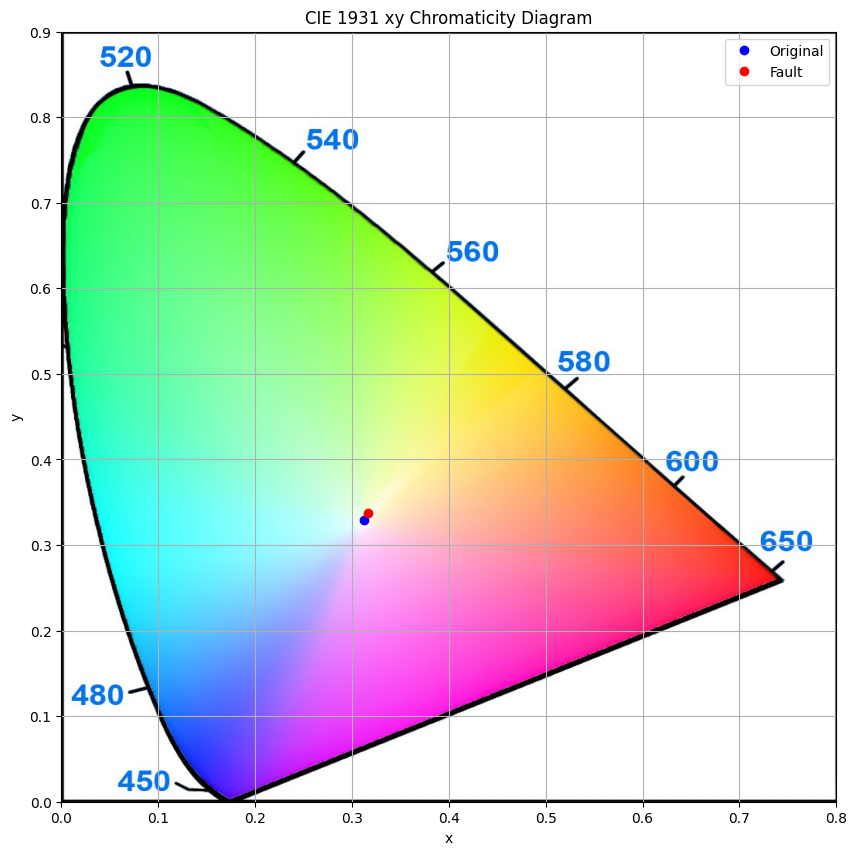

In [7]:
def plot_and_save_chromaticity_diagram(x, y, x_fault, y_fault, save_path):
    cie_diagram_path = '../input files/CIE_1931_Chromaticity_Diagram.jpg'
    cie_diagram = Image.open(cie_diagram_path)

    plt.figure(figsize=(10, 10))

    plt.imshow(cie_diagram, extent=[0, 0.8, 0, 0.9], aspect='auto')

    plt.plot(x, y, 'bo', label='Original')
    plt.plot(x_fault, y_fault, 'ro', label='Fault')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('CIE 1931 xy Chromaticity Diagram')
    plt.legend()
    plt.grid(True)
    plt.xlim(0, 0.8)
    plt.ylim(0, 0.9)

    plt.savefig(save_path, format='png')
    plt.show()

save_path = '../output files/cie1931_chromaticity_diagram.png'
plot_and_save_chromaticity_diagram(x, y, x_fault, y_fault, save_path)

Automatisierung der Forschung

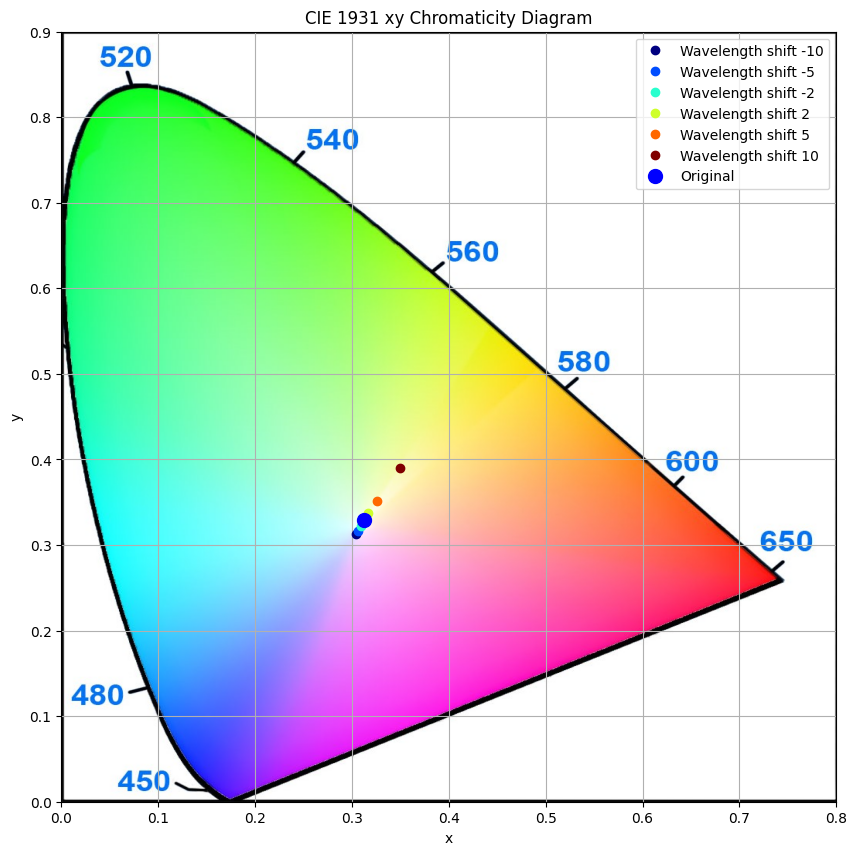

results DataFrame:
                  Label  New_Sum_X  New_Sum_Y   New_Sum_Z         x         y
0  Wavelength shift -10  97.371849        100  122.230782  0.304665  0.312889
1   Wavelength shift -5  96.643622        100  119.209444  0.305977  0.316603
2   Wavelength shift -2  95.705195        100  114.060432  0.308960  0.322825
3    Wavelength shift 2  93.997784        100  102.616892  0.316902  0.337138
4    Wavelength shift 5  92.730736        100   92.217671  0.325430  0.350941
5   Wavelength shift 10  89.695536        100   66.548476  0.350040  0.390253


In [8]:
wavelength_shift_steps = [-10, -5, -2, 2, 5, 10]
x_shift_steps = [0]
y_shift_steps = [0]
z_shift_steps = [0]

xy_shift_steps = [(x, y) for x in x_shift_steps for y in y_shift_steps if x == y]
xz_shift_steps = [(x, z) for x in x_shift_steps for z in z_shift_steps if x == z]
yz_shift_steps = [(y, z) for y in y_shift_steps for z in z_shift_steps if y == z]

apply_individual_shifts = True
apply_combined_shifts = False

x_faults = []
y_faults = []
labels = []

results_df = pd.DataFrame(columns=['Label', 'New_Sum_X', 'New_Sum_Y', 'New_Sum_Z', 'x', 'y'])

def apply_shifts_and_calculate(var_name, shift):
    if shift == 0:
        return

    wavelength_shift = 0
    x_shift = 0
    y_shift = 0
    z_shift = 0

    if var_name == 'wavelength':
        wavelength_shift = shift
    elif var_name == 'x':
        x_shift = shift
    elif var_name == 'y':
        y_shift = shift
    elif var_name == 'z':
        z_shift = shift

    cmf_fault = cmf.copy()
    cmf_fault['Wavelength'] = cmf_fault['Wavelength'].shift(wavelength_shift)
    cmf_fault['x'] = cmf_fault['x'].shift(x_shift)
    cmf_fault['y'] = cmf_fault['y'].shift(y_shift)
    cmf_fault['z'] = cmf_fault['z'].shift(z_shift)

    merged_fault_df = pd.merge(spectrum, cmf_fault, left_on='Wellenlänge', right_on='Wavelength', how='left')
    merged_fault_df['X'] = merged_fault_df['Intensität'] * merged_fault_df['x']
    merged_fault_df['Y'] = merged_fault_df['Intensität'] * merged_fault_df['y']
    merged_fault_df['Z'] = merged_fault_df['Intensität'] * merged_fault_df['z']
    merged_fault_df = merged_fault_df.drop(columns=['Wavelength'])

    sum_X_fault = merged_fault_df['X'].sum()
    sum_Y_fault = merged_fault_df['Y'].sum()
    sum_Z_fault = merged_fault_df['Z'].sum()

    norm_sum_X_fault = ((sum_X_fault * 683) / sum_Y_fault)
    norm_sum_Y_fault = ((sum_Y_fault * 683) / sum_Y_fault)
    norm_sum_Z_fault = ((sum_Z_fault * 683) / sum_Y_fault)

    total_sum_fault = norm_sum_X_fault + norm_sum_Y_fault + norm_sum_Z_fault
    x_fault = norm_sum_X_fault / total_sum_fault
    y_fault = norm_sum_Y_fault / total_sum_fault

    verhaeltnis = 100 / norm_sum_Y_fault
    neue_summe_X = norm_sum_X_fault * verhaeltnis
    neue_summe_Z = norm_sum_Z_fault * verhaeltnis

    x_faults.append(x_fault)
    y_faults.append(y_fault)
    labels.append(f"{var_name.capitalize()} shift {shift}")

    results_df.loc[len(results_df)] = [
        f"{var_name.capitalize()} shift {shift}",
        neue_summe_X,
        100,
        neue_summe_Z,
        x_fault,
        y_fault
    ]

def apply_combined_shifts_and_calculate(var1, shift1, var2, shift2):
    wavelength_shift = 0
    x_shift = 0
    y_shift = 0
    z_shift = 0

    if var1 == 'wavelength':
        wavelength_shift = shift1
    elif var1 == 'x':
        x_shift = shift1
    elif var1 == 'y':
        y_shift = shift1
    elif var1 == 'z':
        z_shift = shift1

    if var2 == 'wavelength':
        wavelength_shift += shift2
    elif var2 == 'x':
        x_shift += shift2
    elif var2 == 'y':
        y_shift += shift2
    elif var2 == 'z':
        z_shift += shift2

    cmf_fault = cmf.copy()
    cmf_fault['Wavelength'] = cmf_fault['Wavelength'].shift(wavelength_shift)
    cmf_fault['x'] = cmf_fault['x'].shift(x_shift)
    cmf_fault['y'] = cmf_fault['y'].shift(y_shift)
    cmf_fault['z'] = cmf_fault['z'].shift(z_shift)

    merged_fault_df = pd.merge(spectrum, cmf_fault, left_on='Wellenlänge', right_on='Wavelength', how='left')
    merged_fault_df['X'] = merged_fault_df['Intensität'] * merged_fault_df['x']
    merged_fault_df['Y'] = merged_fault_df['Intensität'] * merged_fault_df['y']
    merged_fault_df['Z'] = merged_fault_df['Intensität'] * merged_fault_df['z']
    merged_fault_df = merged_fault_df.drop(columns=['Wavelength'])

    sum_X_fault = merged_fault_df['X'].sum()
    sum_Y_fault = merged_fault_df['Y'].sum()
    sum_Z_fault = merged_fault_df['Z'].sum()

    norm_sum_X_fault = ((sum_X_fault * 683) / sum_Y_fault)
    norm_sum_Y_fault = ((sum_Y_fault * 683) / sum_Y_fault)
    norm_sum_Z_fault = ((sum_Z_fault * 683) / sum_Y_fault)

    total_sum_fault = norm_sum_X_fault + norm_sum_Y_fault + norm_sum_Z_fault
    x_fault = norm_sum_X_fault / total_sum_fault
    y_fault = norm_sum_Y_fault / total_sum_fault

    verhaeltnis = 100 / norm_sum_Y_fault
    neue_summe_X = norm_sum_X_fault * verhaeltnis
    neue_summe_Z = norm_sum_Z_fault * verhaeltnis

    x_faults.append(x_fault)
    y_faults.append(y_fault)
    labels.append(f"{var1.capitalize()} {shift1}, {var2.capitalize()} {shift2}")

    results_df.loc[len(results_df)] = [
        f"{var1.capitalize()} {shift1}, {var2.capitalize()} {shift2}",
        neue_summe_X,
        100,
        neue_summe_Z,
        x_fault,
        y_fault
    ]

def plot_chromaticity_diagram(x, y, x_faults, y_faults, labels):
    cie_diagram_path = '../input files/CIE_1931_Chromaticity_Diagram.jpg'
    cie_diagram = Image.open(cie_diagram_path)

    plt.figure(figsize=(10, 10))
    plt.imshow(cie_diagram, extent=[0, 0.8, 0, 0.9], aspect='auto')

    colors = cm.jet(np.linspace(0, 1, len(x_faults)))

    for (x_fault, y_fault, label, color) in zip(x_faults, y_faults, labels, colors):
        plt.plot(x_fault, y_fault, 'o', label=label, color=color)

    plt.plot(x, y, 'bo', label='Original', markersize=10)

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('CIE 1931 xy Chromaticity Diagram')
    plt.legend()
    plt.grid(True)
    plt.xlim(0, 0.8)
    plt.ylim(0, 0.9)
    plt.show()

def write_latex_file(x, y, x_faults, y_faults, labels, file_path):
    with open(file_path, 'w') as file:
        file.write('\\documentclass{article}\n')
        file.write('\\usepackage{pstricks}\n')
        file.write('\\usepackage{pst-plot}\n')
        file.write('\\usepackage{auto-pst-pdf}\n')
        file.write('\\usepackage{tcolorbox}\n')
        file.write('\\usepackage{graphicx}\n') 
        file.write('\\usepackage{color}\n') 
        file.write('\\usepackage{amsmath}\n') 
        file.write('\\usepackage{multicol}\n') 
        file.write('\\begin{document}\n\n')
        file.write('\\begin{figure}[htbp]\n')
        file.write('    \\centering\n')
        file.write('    \\psset{unit=1.6}\n')
        file.write('    \\begin{pspicture}(-1,-1)(8,8)\n')
        file.write('        \\psChromaticityDiagram[ColorSpace=CIE, bgcolor=white, textcolor=black, PSfont=Times New Roman, fontscale=10, contrast=0.7]\n')

        file.write(f'        \\psdot[dotsize=5pt, dotstyle=*, linecolor=blue]({x*10:.2f}, {y*10:.2f})\n')

        colors = ['red', 'green', 'orange', 'cyan', 'magenta', 'yellow']
        for i, (x_fault, y_fault) in enumerate(zip(x_faults, y_faults)):
            color = colors[i % len(colors)]
            file.write(f'        \\psdot[dotsize=2pt, dotstyle=*, linecolor={color}]({x_fault*10:.2f}, {y_fault*10:.2f})\n')

        file.write('    \\end{pspicture}\n')
        
        file.write('    \\begin{tcolorbox}[colback=white, colframe=black, boxrule=0.5mm, width=0.4\\textwidth]\n')
        file.write('        \\centering\n')
        file.write('        \\footnotesize\n')
        file.write('        \\begin{tabular}{ll}\n')
        
        file.write('            \\textcolor{blue}{\\rule{0.2cm}{0.2cm}} & Original Point \\\\\n')
        
        for i, label in enumerate(labels):
            color = colors[i % len(colors)]
            file.write(f'            \\textcolor{{{color}}}{{\\rule{{0.2cm}}{{0.2cm}}}} & {label} \\\\\n')
        
        file.write('        \\end{tabular}\n')
        file.write('    \\end{tcolorbox}\n')
        
        file.write('    \\caption{platzhalter dies das}\n')
        file.write('    \\label{fig:platzhalter}\n')
        file.write('\\end{figure}\n\n')
        file.write('\\end{document}\n')

if apply_individual_shifts:
    if wavelength_shift_steps:
        for shift in wavelength_shift_steps:
            apply_shifts_and_calculate('wavelength', shift)

    if x_shift_steps:
        for shift in x_shift_steps:
            apply_shifts_and_calculate('x', shift)

    if y_shift_steps:
        for shift in y_shift_steps:
            apply_shifts_and_calculate('y', shift)

    if z_shift_steps:
        for shift in z_shift_steps:
            apply_shifts_and_calculate('z', shift)

if apply_combined_shifts:
    for shift_x, shift_y in xy_shift_steps:
        apply_combined_shifts_and_calculate('x', shift_x, 'y', shift_y)

    for shift_x, shift_z in xz_shift_steps:
        apply_combined_shifts_and_calculate('x', shift_x, 'z', shift_z)

    for shift_y, shift_z in yz_shift_steps:
        apply_combined_shifts_and_calculate('y', shift_y, 'z', shift_z)

plot_chromaticity_diagram(x, y, x_faults, y_faults, labels)

write_latex_file(x, y, x_faults, y_faults, labels, '../output files/plot_points.tex')

print("results DataFrame:")
print(results_df)

file_path = '../output files/results.xlsx'
sheet_name = 'results'

if os.path.isfile(file_path):
    book = load_workbook(file_path)
    with pd.ExcelWriter(file_path, engine='openpyxl', mode='a', if_sheet_exists='new') as writer:
        results_df.to_excel(writer, sheet_name=sheet_name, index=False)
else:
    with pd.ExcelWriter(file_path, engine='openpyxl', mode='w') as writer:
        results_df.to_excel(writer, sheet_name=sheet_name, index=False)